<a href="https://colab.research.google.com/github/suzy7526/Projects/blob/main/Big_Data_Final_Project_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Enhancing Financial Services: Unveiling Consumer Insights
#####Consumer Complaints Dataset URL: https://www.kaggle.com/datasets/ashwinik/consumer-complaints-financial-products
#####State Population Dataset URL:https://www2.census.gov/programs-surveys/popest/tables/2010-2016/state/totals/

In [ ]:
!pip install pyspark
!pip install findspark
!pip install geopandas matplotlib
!pip install plotly-express

import pyspark
from pyspark.sql.functions import col,desc
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, year
import pyspark.sql.types as T
import plotly.express as px

import matplotlib
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
#import seaborn as sns
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=6f284bbf656875041e54464c24765ad3755efb5ea3c43a12f26f4f6ac5742bde
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder.appName('project').getOrCreate()

In [ ]:
spark

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/Big Data Project/Consumer_Complaints.csv')
pop_df = pd.read_csv('/content/drive/Shareddrives/Big Data Project/population.csv')

<ipython-input-5-656f2cfbe585>:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/Shareddrives/Big Data Project/Consumer_Complaints.csv')


In [ ]:
df = spark.createDataFrame(df)
pop_df = spark.createDataFrame(pop_df)

In [ ]:
df.show()

+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+--------------+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|Date received|             Product|         Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|State|ZIP code|          Tags|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+--------------+--------------------------+-------------+--------------------+----------------------------+----------------+-

In [ ]:
df.columns

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

In [ ]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[Date received: string, Product: string, Sub-product: string, Issue: string, Sub-issue: string, Consumer complaint narrative: string, Company public response: string, Company: string, State: string, ZIP code: string, Tags: string, Consumer consent provided?: string, Submitted via: string, Date sent to company: string, Company response to consumer: string, Timely response?: string, Consumer disputed?: string, Complaint ID: bigint]>

# Q-1 What are the top 10 banks that have received the most complaints?


In [ ]:
total_complaint_counts = df.groupby('Company').count().alias('count')
sorted_total_complaint_counts = total_complaint_counts.orderBy(desc('count'))

unique_bank_names = df.select('Company').distinct().filter(col('Company').isNotNull()).count()
print('The number of total banks is:', unique_bank_names)

top_10_banks_in_us = sorted_total_complaint_counts.limit(10)
print('Top 10 banks that have received the most complaints:')
top_10_banks_in_us.show()

The number of total banks is: 3933
Top 10 banks that have received the most complaints:
+--------------------+-----+
|             Company|count|
+--------------------+-----+
|     Bank of America|61720|
|Wells Fargo & Com...|48902|
|             Equifax|41771|
|            Experian|39473|
|JPMorgan Chase & Co.|38928|
|TransUnion Interm...|33798|
|            Citibank|31249|
|               Ocwen|22951|
|         Capital One|18100|
| Nationstar Mortgage|14987|
+--------------------+-----+



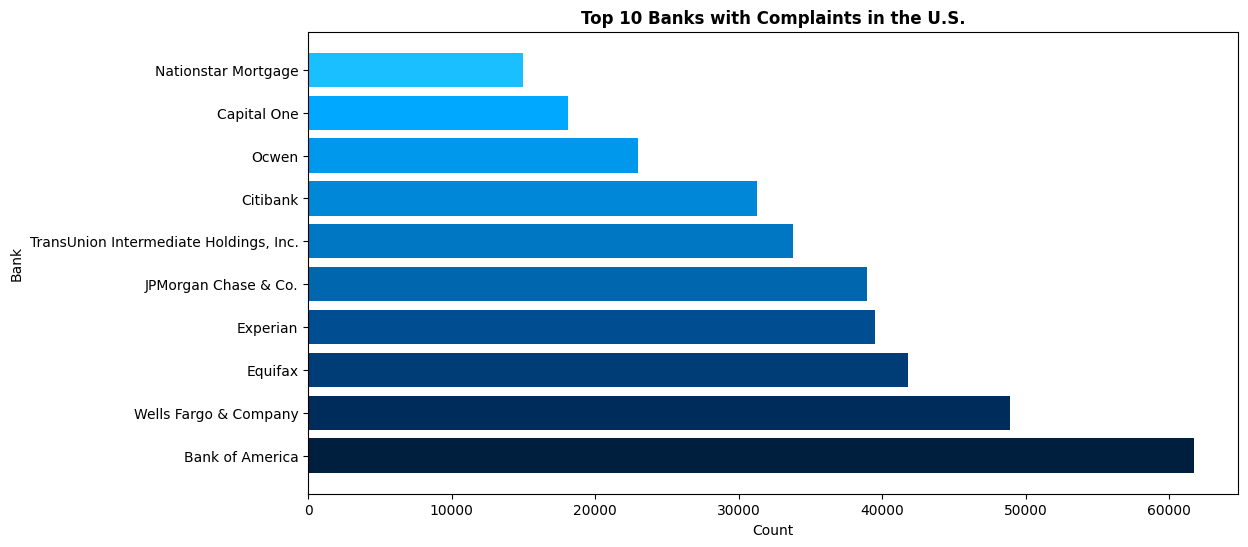

In [ ]:
filtered_banks = df.filter(F.col('Company').isNotNull())
bank_counts = filtered_banks.groupBy('Product', 'Company').count()

top_10_banks = bank_counts.groupBy('Company').sum('count').orderBy(F.desc('sum(count)')).limit(10)
top_10_banks_pd = top_10_banks.toPandas()

custom_colors = ['#001F3F', '#002C5B', '#003C75', '#004E91', '#0066AD', '#0077C2', '#0087D7', '#0098EC', '#00A9FF', '#19BFFF']

plt.figure(figsize=(12, 6))
plt.barh(top_10_banks_pd['Company'], top_10_banks_pd['sum(count)'], color = custom_colors)
plt.title('Top 10 Banks with Complaints in the U.S.', fontweight="bold")
plt.xlabel('Count')
plt.ylabel('Bank')
plt.show()

#Q-2 What is the percentage of complaints from each state?

In [ ]:
complaint_counts_by_states = df.groupBy('State').agg(F.count('*').alias('Complaints'))

complaint_counts_by_states = complaint_counts_by_states.filter(
    (complaint_counts_by_states.State.isNotNull())
)

state_df = (complaint_counts_by_states.withColumn('Complaints', complaint_counts_by_states['Complaints'].cast(T.IntegerType()))).join(pop_df, on="State", how="inner")
state_df = state_df.withColumn("Population", (F.regexp_replace(col('Population'), '[^0-9]', '')).cast(T.IntegerType()))
percentage_df = state_df.withColumn("percentage_complaints", (col("Complaints") / col("Population")) * 100)
sorted_states = percentage_df.orderBy('percentage_complaints', ascending=False)
sorted_states.show()

fig = px.choropleth(sorted_states.toPandas(),
                    locations='State',
                    locationmode="USA-states",
                    scope="usa",
                    color='percentage_complaints',
                    color_continuous_scale="Viridis_r")

fig.update_layout(
    title_text='Total Complaints Percentage by State',
    title_font_size=22,
    title_font_color="black",
    title_x=0.45
)

fig.show()

+-----+----------+----------+---------------------+
|State|Complaints|Population|percentage_complaints|
+-----+----------+----------+---------------------+
|   DE|      3457|    952065|   0.3631054602364335|
|   MD|     21184|   6016447|   0.3521014977776751|
|   FL|     64688|  20612439|   0.3138299160036326|
|   NJ|     26907|   8944469|   0.3008227766231847|
|   GA|     30641|  10310371|   0.2971862021259953|
|   NV|      8270|   2940058|  0.28128696780811807|
|   VA|     21731|   8411808|  0.25833922980648155|
|   CA|     97640|  39250017|   0.2487642234651771|
|   NH|      3227|   1334795|  0.24175997063219443|
|   NY|     46245|  19745289|  0.23420776469769575|
|   CT|      7804|   3576452|  0.21820508146062076|
|   AZ|     15063|   6931071|  0.21732572065702402|
|   CO|     11570|   5540545|     0.20882422216587|
|   RI|      2173|   1056426|   0.2056935365089462|
|   OR|      7934|   4093465|  0.19382112708915308|
|   MA|     13134|   6811779|  0.19281306689485964|
|   WA|     

# Q-3 What are the most common complaints (issues and products) reported by consumers?

In [ ]:
product_counts = df.filter(col('Product').isNotNull()).groupBy('Product').count()
sorted_product_counts = product_counts.orderBy(desc('count'))
top_3_product_complaints = sorted_product_counts.limit(3)

top_3_product_complaints.show()

+----------------+------+
|         Product| count|
+----------------+------+
|        Mortgage|210324|
| Debt collection|124236|
|Credit reporting|119195|
+----------------+------+



In [ ]:
issue_counts = df.filter(col('Issue').isNotNull()).groupBy('Issue').count()
sorted_issue_counts = issue_counts.orderBy(desc('count'))
top_3_issue_complaints = sorted_issue_counts.limit(3)

top_3_issue_complaints.show()

+--------------------+------+
|               Issue| count|
+--------------------+------+
|Loan modification...|106455|
|Incorrect informa...| 86904|
|Loan servicing, p...| 70166|
+--------------------+------+



# Q-4 How do consumers typically submit their complaints?

In [ ]:
submission_counts = df.groupBy('Submitted via').count()
sorted_submission_counts = submission_counts.orderBy(F.desc('count'))
sorted_submission_counts.show()

+-------------+------+
|Submitted via| count|
+-------------+------+
|          Web|446035|
|     Referral|123224|
|        Phone| 47389|
|  Postal mail| 43869|
|          Fax|  9733|
|        Email|   348|
+-------------+------+



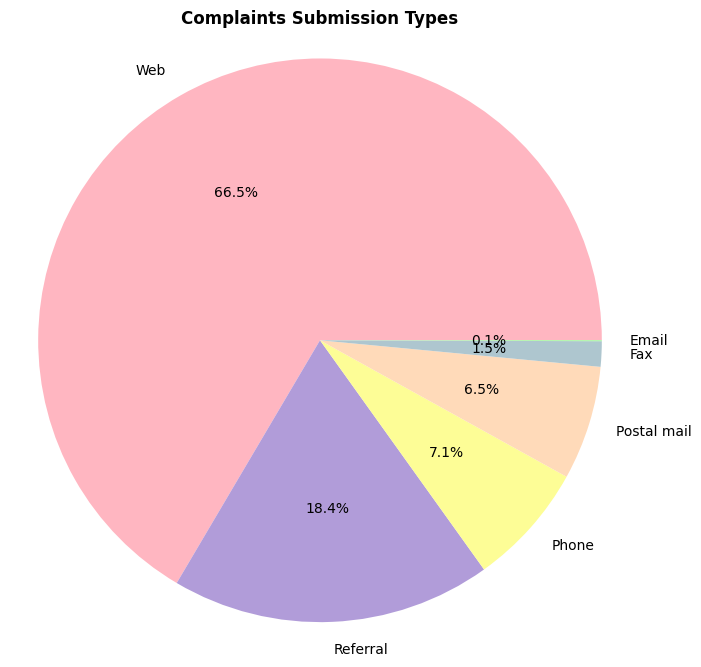

In [ ]:
sorted_submission_counts_pandas = sorted_submission_counts.toPandas()

plt.figure(figsize=(8, 8))
pie_colors = ['#FFB6C1', '#B19CD9', '#FDFD96', '#FFDAB9', '#AEC6CF', '#98FB98']
plt.pie(sorted_submission_counts_pandas['count'], labels=sorted_submission_counts_pandas['Submitted via'], colors = pie_colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Complaints Submission Types', fontweight="bold")
plt.show()

##How complaints are submitted each year

+----+-----+----+-----+-----------+--------+------+
|Year|Email| Fax|Phone|Postal mail|Referral|   Web|
+----+-----+----+-----+-----------+--------+------+
|2015|    8|2145|10274|       9489|   21549|125135|
|2013|  151|2068| 9491|       7994|   28179| 60343|
|2014|   17|2319|10270|      11257|   23629|105596|
|2012|  154| 958| 6325|       4572|   27948| 32446|
|2016|    8|2233|10811|      10510|   21122|121057|
|2011|   10|  10|  218|         47|     797|  1458|
+----+-----+----+-----+-----------+--------+------+



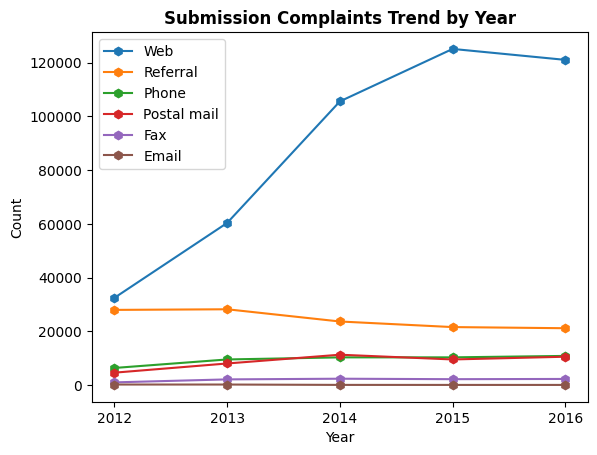

In [ ]:
year_df = df.withColumn("Date received", to_date(col("Date received"), "MM/dd/yyyy"))
complaints_year_df = year_df.withColumn("Year", year(col("Date received")))

grouped_data = complaints_year_df.groupBy("Year", "Submitted via").count()
pivoted_data = grouped_data.groupBy("Year").pivot("Submitted via").sum("count").fillna(0)
pivoted_data.show()

pandas_data = pivoted_data.toPandas()
pandas_data = pandas_data.sort_values(by="Year")

filtered_data = pandas_data[(pandas_data["Year"] > 2011)]

plt.plot(filtered_data["Year"], filtered_data["Web"], marker='h', label="Web")
plt.plot(filtered_data["Year"], filtered_data["Referral"], marker='h', label="Referral")
plt.plot(filtered_data["Year"], filtered_data["Phone"], marker='h', label="Phone")
plt.plot(filtered_data["Year"], filtered_data["Postal mail"], marker='h', label="Postal mail")
plt.plot(filtered_data["Year"], filtered_data["Fax"], marker='h', label="Fax")
plt.plot(filtered_data["Year"], filtered_data["Email"], marker='h', label="Email")

plt.title('Submission Complaints Trend by Year', fontweight="bold")
plt.xlabel('Year')
plt.ylabel('Count')

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=1))

plt.legend(loc='best')
plt.show()



# Q-5 Identify the product categories that cause the most consumer disputes.


Text(0.5, 1.0, 'Ratio of Disputed Customers in the Data Set')

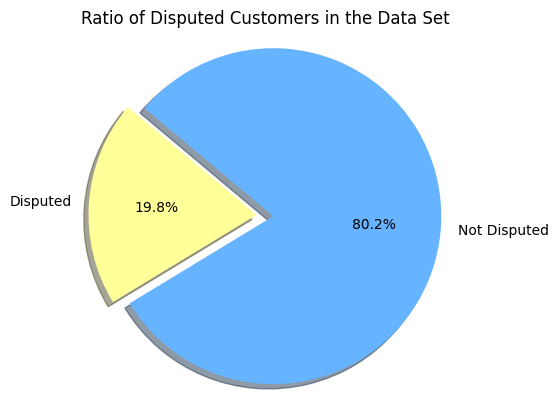

In [ ]:
disputed_df = df.filter(col('Consumer disputed?') == 'Yes')
disputed_df_size = disputed_df.count()
num_rows = df.count()
ratio_disputed = disputed_df_size / num_rows
ratio_not_disputed = 1 - ratio_disputed

labels = ['Disputed', 'Not Disputed']
sizes = [ratio_disputed, ratio_not_disputed]
colors = ['#ffff99', '#66b3ff']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Ratio of Disputed Customers in the Data Set')

In [ ]:
disputed_products = disputed_df.groupBy('Product').count()
sorted_disputed_products = disputed_products.orderBy(col('count').desc())
top_3_products_disputed = sorted_disputed_products.limit(3)
top_3_products_disputed.show()

+----------------+-----+
|         Product|count|
+----------------+-----+
|        Mortgage|48226|
| Debt collection|22423|
|Credit reporting|19127|
+----------------+-----+



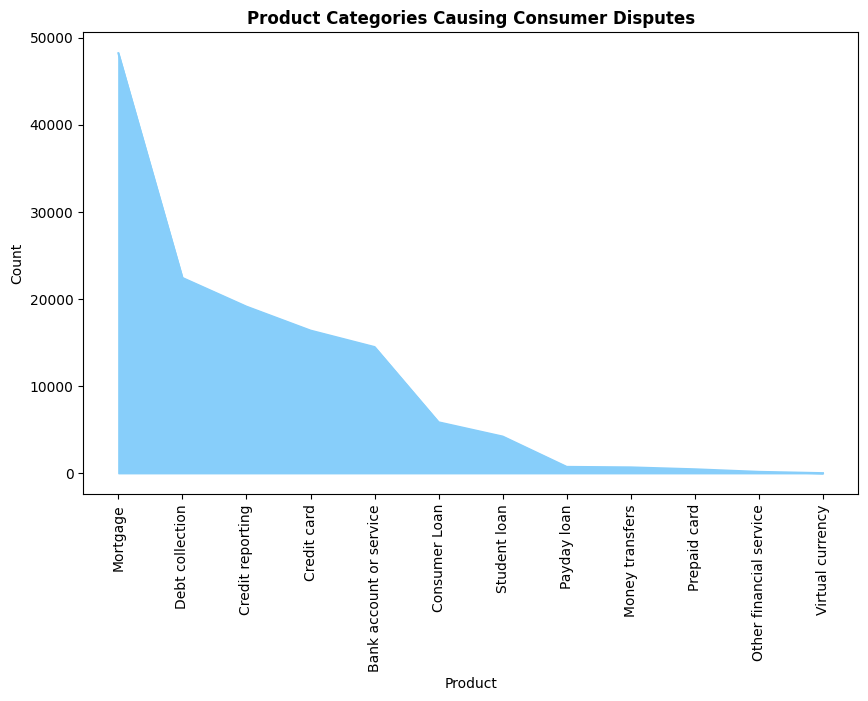

In [ ]:
sorted_disputed_products_pandas = sorted_disputed_products.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(sorted_disputed_products_pandas['Product'], sorted_disputed_products_pandas['count'], color='lightskyblue')
plt.fill_between(sorted_disputed_products_pandas['Product'], sorted_disputed_products_pandas['count'], color='lightskyblue')
plt.title('Product Categories Causing Consumer Disputes', fontweight="bold")
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()